## 1. Library Importing

In [1]:
import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import string # 표준 파이썬 문자열을 처리
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
import numpy as np
from google.colab import drive

## 2. Data Uploading

In [2]:
  # Colab에서 Google 드라이브를 마운트하기 위한 라이브러리

# 구글 드라이브 마운트
drive.mount('/content/drive')

def loadfile(path):
    X = []
    Y = []

    for label in ('0', '25', '50', '75', '100'):
        print("Loading text files for the label: " + label)

        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()

                # 레이블을 숫자로 변환
                if label == '0':
                    Y.append(0)
                elif label == '25':
                    Y.append(1)
                elif label == '50':
                    Y.append(2)
                elif label == '75':
                    Y.append(3)
                elif label == '100':
                    Y.append(4)

                # 텍스트 데이터를 X에 추가
                X.append(text)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_final/'

# loadfile 함수 호출
X, Y = loadfile(directory_path)

Mounted at /content/drive
Loading text files for the label: 0
Loading text files for the label: 25
Loading text files for the label: 50
Loading text files for the label: 75
Loading text files for the label: 100


In [3]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1577,)
Y shape: (1577,)


In [4]:
def count_txt_files(path):
    file_counts = {}

    for label in ('0', '25', '50', '75', '100'):
        label_path = os.path.join(path, label)
        txt_files = [filename for filename in os.listdir(label_path) if filename.endswith('.txt')]
        file_counts[label] = len(txt_files)

    return file_counts

# .txt 파일 수 확인
file_counts = count_txt_files(directory_path)

# 결과 출력
for label, count in file_counts.items():
    print(f"Number of .txt files in label {label}: {count}")

Number of .txt files in label 0: 365
Number of .txt files in label 25: 300
Number of .txt files in label 50: 305
Number of .txt files in label 75: 303
Number of .txt files in label 100: 304


## 3. 호감도 가중치 증가


In [5]:
# 3-1. 이모지 사용량에 따른 호감도 증가 함수
import re
import numpy as np

# 이모지 카운트 함수
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))

# 호감도 라벨링 함수
def label_likeability(text):
    emoji_count = count_emojis(text)
    exclamation_question_count = len(re.findall(r'[!?]', text))
    a_contributions = len(re.findall(r'A:', text))

    # "A"의 발화에 대한 디폴트 호감도 설정
    likeability = 75 if a_contributions > 0 else 0

    # 이모지 사용에 따른 추가적인 호감도 조정
    if emoji_count == 0 and exclamation_question_count == 0:
        likeability = 0
    elif emoji_count == 0 and exclamation_question_count >= 2:
        likeability = 25
    elif emoji_count == 1:
        likeability = 50 if exclamation_question_count >= 2 else 75
    elif emoji_count >= 2:
        likeability = 100

    return likeability

# 예시 텍스트를 사용하여 함수 테스트
example_text = """A: 안녕! 😀
B: 안녕! 😊
A: 오늘 날씨 어때? 🌤️"""
likeability = label_likeability(example_text)
print("호감도 라벨:", likeability)

호감도 라벨: 100


In [6]:
# 3-2. 답장 속도 기반 호감도 예측
from datetime import datetime
import re
import numpy as np
# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())


# 호감도 레이블 생성 함수
def create_likeability_labels(conversation):
    response_times = []
    last_message_time = None
    for line in conversation:
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes
                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time
    # 평균 응답 시간 계산 및 호감도 레이블 생성
    avg_response_times = np.mean(response_times) if response_times else 0
    likeability_labels = []
    for response_time in response_times:
        if response_time <= 10:
            likeability = 100
        elif response_time <= 30:
            likeability = 75
        elif response_time <= 60:
            likeability = 50
        elif response_time <= 180:
            likeability = 25
        else:
            likeability = 0
        likeability_labels.append(likeability)
    return likeability_labels
# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation)


## 4.데이터 정제

In [7]:
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import wordnet
import random

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


# 텍스트 전처리 함수 정의
def preprocess_text(text):
    # 숫자와 이모지 패턴 정의
    emoji_pattern = re.compile('['
                               u'\U0001F600-\U0001F64F'  # emoticons
                               u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                               ']', flags=re.UNICODE)

    # 불용어 제거 (숫자와 이모지 제외)
    words = text.split()
    filtered_words = [word for word in words if word.isalnum() or emoji_pattern.match(word)]
    return ' '.join(filtered_words)

# 데이터셋에 텍스트 전처리 적용
X_train_preprocessed = [preprocess_text(text) for text in X_train]
X_val_preprocessed = [preprocess_text(text) for text in X_val]

# 토크나이징 및 시퀀싱
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_preprocessed)

# 텍스트를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train_preprocessed)
X_val_seq = tokenizer.texts_to_sequences(X_val_preprocessed)

# 시퀀스 패딩
max_sequence_length = 100  # 최대 시퀀스 길이 설정
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam

# 기존 모델 정의
model = Sequential()
model.add(Embedding(10000, 128, input_length=max_sequence_length))  # 임베딩 차원 변경
model.add(LSTM(128, return_sequences=True))  # return_sequences=True로 설정하여 출력 형태를 3D로 유지
model.add(Dropout(0.3))  # Dropout 비율 조정
# Batch Normalization 추가
model.add(BatchNormalization())
model.add(LSTM(64))  # 두 번째 LSTM 레이어
# Batch Normalization 추가
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
import numpy as np

# X_train과 y_train을 NumPy 배열로 변환
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# X_val과 y_val을 NumPy 배열로 변환
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

# 데이터의 형상(shape) 확인
print("X_train shape:", X_train_np.shape)
print("y_train shape:", y_train_np.shape)
print("X_val shape:", X_val_np.shape)
print("y_val shape:", y_val_np.shape)

X_train shape: (1103,)
y_train shape: (1103,)
X_val shape: (474,)
y_val shape: (474,)


In [14]:
# 모델 훈련
from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=99, verbose=1, restore_best_weights=True)

history = model.fit(X_train_padded, y_train_np, epochs=30, batch_size=8, validation_data=(X_val_padded, y_val_np))

Epoch 1/30
138/138 [==============================] - 44s 126ms/step - loss: 1.4414 - accuracy: 0.4397 - val_loss: 1.5463 - val_accuracy: 0.2489
Epoch 2/30
138/138 [==============================] - 10s 75ms/step - loss: 0.6067 - accuracy: 0.7833 - val_loss: 1.3439 - val_accuracy: 0.4768
Epoch 3/30
138/138 [==============================] - 6s 43ms/step - loss: 0.3135 - accuracy: 0.8885 - val_loss: 1.1956 - val_accuracy: 0.5759
Epoch 4/30
138/138 [==============================] - 6s 41ms/step - loss: 0.2201 - accuracy: 0.9220 - val_loss: 1.2763 - val_accuracy: 0.5970
Epoch 5/30
138/138 [==============================] - 4s 26ms/step - loss: 0.1670 - accuracy: 0.9510 - val_loss: 1.8502 - val_accuracy: 0.5844
Epoch 6/30
138/138 [==============================] - 3s 23ms/step - loss: 0.1383 - accuracy: 0.9501 - val_loss: 1.6855 - val_accuracy: 0.6118
Epoch 7/30
138/138 [==============================] - 3s 24ms/step - loss: 0.1005 - accuracy: 0.9710 - val_loss: 1.9058 - val_accuracy: 0.5

## 5.평가지표

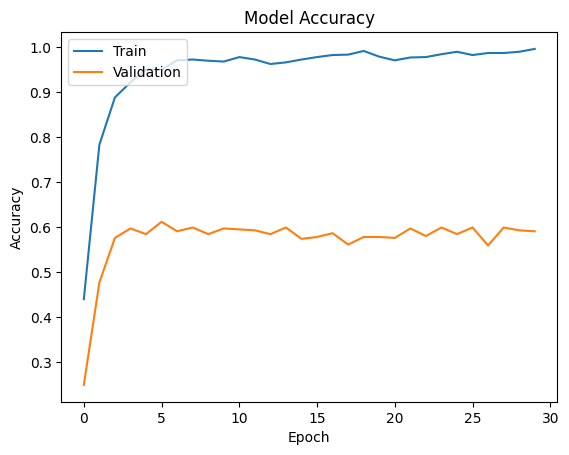

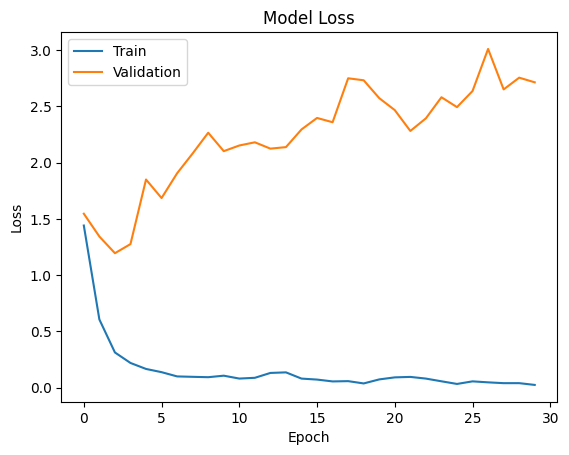

In [15]:
import matplotlib.pyplot as plt

# Accuracy 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


15/15 [==============================] - 1s 8ms/step


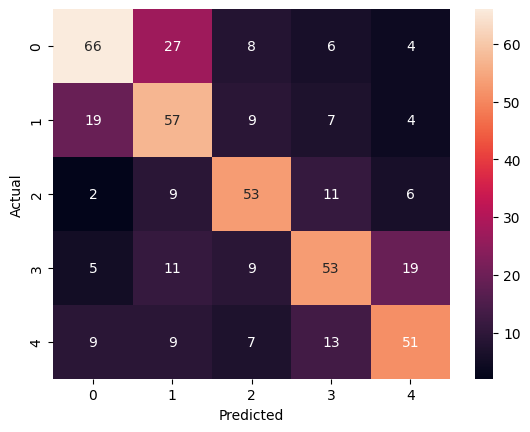

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델 예측
y_pred = model.predict(X_val_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix 생성
cm = confusion_matrix(y_val_np, y_pred_classes)

# 시각화
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val_np, y_pred_classes)
precision = precision_score(y_val_np, y_pred_classes, average='macro')
recall = recall_score(y_val_np, y_pred_classes, average='macro')
f1 = f1_score(y_val_np, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5907172995780591
Precision: 0.5940401882189807
Recall: 0.5924182085382808
F1 Score: 0.5918533778638606


In [19]:
import time
from tensorflow.keras.models import load_model
import os

# 모델 저장 및 크기 확인 (MB 단위로 변환)
model.save('lstm_likeability.h5')
model_size = os.path.getsize('lstm_likeability.h5') / (1024 * 1024)  # Bytes to Megabytes
print("Model Size:", model_size, "MB")

# 추론 시간 측정 (초 단위)
start_time = time.time()
y_pred = model.predict(X_val_padded[0:1])
end_time = time.time()
inference_time = end_time - start_time
print("Inference Time:", round(inference_time, 4),"seconds")


Model Size: 16.79326629638672 MB
1/1 [==============================] - 0s 50ms/step
Inference Time: 0.0946 seconds


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from sklearn.metrics import accuracy_score

# 랜덤 이미지 샘플 선택
random_image_samples = random.sample(range(len(X_val_padded)), 50)

true_labels = []  # 실제 라벨을 저장할 리스트
predicted_labels = []  # 모델의 예측을 저장할 리스트

# 선택한 랜덤 이미지 샘플에 대한 텍스트 데이터 추론
for sample_index in random_image_samples:
    text_data = X_val_padded[sample_index]
    text_data = text_data.reshape(1, -1)  # 모델의 입력 형태로 변환

    # 모델을 사용하여 추론 확률 계산
    predictions = model.predict(text_data)

    # 예측한 클래스(라벨)를 실제 라벨과 함께 저장
    true_label = y_val_np[sample_index]
    predicted_label = y_pred_classes[sample_index]

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# 정확도 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy for random image samples:", accuracy)


1/1 [==============================] - 0s 33ms/step
Accuracy for random image samples: 0.6
